In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [3]:
data = pd.read_csv('/Users/harashimakoshi/CS332/332Project2/data/espace_5stores_daily_2024_2025.csv')

In [4]:
# 指数平滑化を行う
# データを[0,1]の範囲に収まるようにする

def exponential_smoothing(series, alpha=0.3):
    '''Apply exponential smoothing to a time series'''
    smoothed = np.zeros_like(series)
    smoothed[0] = series[0]
    for i in range(1, len(series)):
        smoothed[i] = alpha * series[i] + (1 - alpha) * smoothed[i-1]
    return smoothed

def normalize_to_01(series):
    '''Normalize series to [0,1] range'''
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return np.zeros_like(series)
    return (series - min_val) / (max_val - min_val)

# Process each store
stores = data['store'].unique()
processed_data = []

for store in stores:
    store_data = data[data['store'] == store].copy()
    
    # Apply exponential smoothing to ROI
    store_data['roi_smoothed'] = exponential_smoothing(store_data['roi'].values)
    
    # Normalize smoothed ROI to [0,1]
    store_data['roi_normalized'] = normalize_to_01(store_data['roi_smoothed'])
    
    # Also normalize avg_diff to [0,1]
    store_data['avg_diff_normalized'] = normalize_to_01(store_data['avg_diff'].values)
    
    processed_data.append(store_data)

# Combine all processed data
final_data = pd.concat(processed_data, ignore_index=True)

print('Data processing completed!')
print(f'Final data shape: {final_data.shape}')
print('\nFirst few rows of processed data:')
print(final_data.head())

print('\nSummary statistics for normalized ROI:')
print(final_data.groupby('store')['roi_normalized'].describe())

Data processing completed!
Final data shape: (1825, 7)

First few rows of processed data:
   day    store    avg_diff       roi  roi_smoothed  roi_normalized  \
0    0  Store_A  112.734361  0.112734      0.112734        0.320206   
1    1  Store_A  135.714578  0.135715      0.119628        0.370894   
2    2  Store_A  139.016797  0.139017      0.125445        0.413659   
3    3  Store_A  150.885228  0.150885      0.133077        0.469773   
4    4  Store_A  134.983610  0.134984      0.133649        0.473978   

   avg_diff_normalized  
0             0.448600  
1             0.525768  
2             0.536857  
3             0.576712  
4             0.523313  

Summary statistics for normalized ROI:
         count      mean       std  min       25%       50%       75%  max
store                                                                     
Store_A  365.0  0.596118  0.181010  0.0  0.473978  0.593029  0.728956  1.0
Store_B  365.0  0.532896  0.166800  0.0  0.409684  0.545978  0.65377

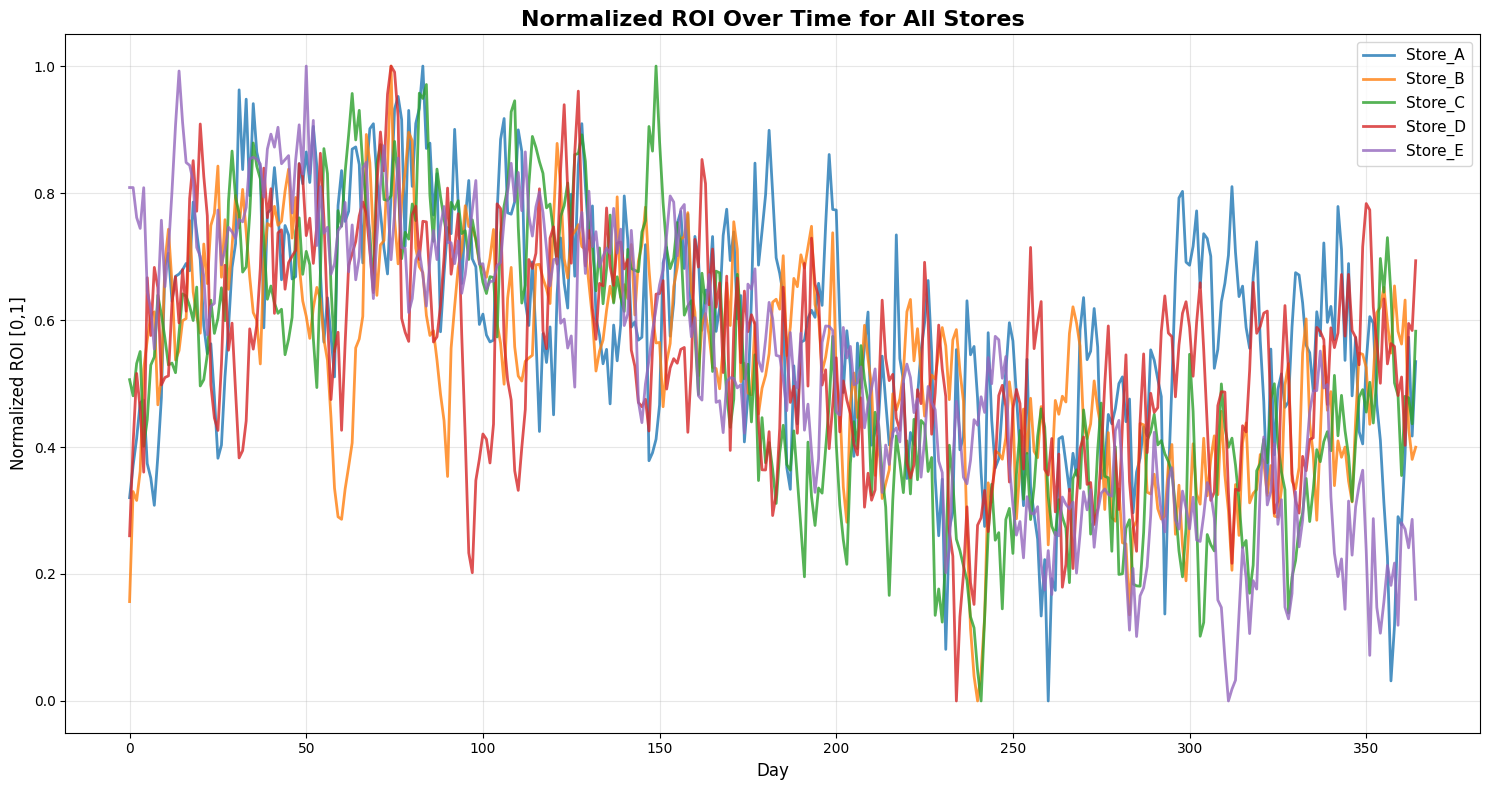

In [ ]:
# 時系列グラフで5つの店舗の正規化されたROIを表示
plt.figure(figsize=(15, 8))

# 各店舗の色を設定
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
store_names = final_data['store'].unique()

for i, store in enumerate(store_names):
    store_data = final_data[final_data['store'] == store]
    plt.plot(store_data['day'], store_data['roi_normalized'], 
             label=store, color=colors[i], linewidth=2, alpha=0.8)

plt.title('Normalized ROI Over Time for All Stores', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Normalized ROI [0,1]', fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

=== 各店舗の正規化されたROIの平均値 ===

Store_A: 0.5961
Store_D: 0.5453
Store_B: 0.5329
Store_E: 0.5244
Store_C: 0.5209

=== 平均値のランキング ===
1. Store_A: 0.5961
2. Store_D: 0.5453
3. Store_B: 0.5329
4. Store_E: 0.5244
5. Store_C: 0.5209

=== 統計サマリー ===
全体平均: 0.5439
最高平均: 0.5961 (Store_A)
最低平均: 0.5209 (Store_C)
標準偏差: 0.0307


/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_3248/3120699623.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(store_data_list, labels=store_averages.index)


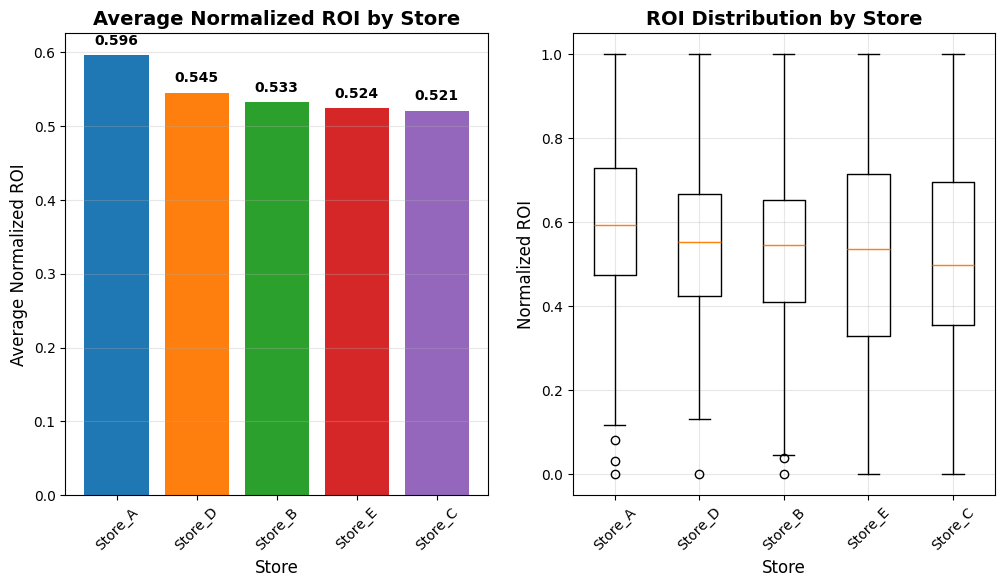

In [6]:
# 各店舗の正規化されたROIの平均を計算
print("=== 各店舗の正規化されたROIの平均値 ===")
print()

store_averages = final_data.groupby('store')['roi_normalized'].mean().sort_values(ascending=False)

for store, avg_roi in store_averages.items():
    print(f"{store}: {avg_roi:.4f}")

print()
print("=== 平均値のランキング ===")
for i, (store, avg_roi) in enumerate(store_averages.items(), 1):
    print(f"{i}. {store}: {avg_roi:.4f}")

print()
print("=== 統計サマリー ===")
print(f"全体平均: {final_data['roi_normalized'].mean():.4f}")
print(f"最高平均: {store_averages.max():.4f} ({store_averages.idxmax()})")
print(f"最低平均: {store_averages.min():.4f} ({store_averages.idxmin()})")
print(f"標準偏差: {store_averages.std():.4f}")

# 平均値を可視化
plt.figure(figsize=(12, 6))

# バープロット
plt.subplot(1, 2, 1)
bars = plt.bar(range(len(store_averages)), store_averages.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Average Normalized ROI by Store', fontsize=14, fontweight='bold')
plt.xlabel('Store', fontsize=12)
plt.ylabel('Average Normalized ROI', fontsize=12)
plt.xticks(range(len(store_averages)), store_averages.index, rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, store_averages.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 箱ひげ図
plt.subplot(1, 2, 2)
store_data_list = [final_data[final_data['store'] == store]['roi_normalized'].values 
                   for store in store_averages.index]
plt.boxplot(store_data_list, labels=store_averages.index)
plt.title('ROI Distribution by Store', fontsize=14, fontweight='bold')
plt.xlabel('Store', fontsize=12)
plt.ylabel('Normalized ROI', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

=== Store_Aを除いた分析 ===

元のデータ数: 1825
Store_Aを除いたデータ数: 1460
除外されたデータ数: 365

=== Store_Aを除いた各店舗の平均ROI ===
Store_D: 0.5453
Store_B: 0.5329
Store_E: 0.5244
Store_C: 0.5209

=== 平均値のランキング (Store_A除く) ===
1. Store_D: 0.5453
2. Store_B: 0.5329
3. Store_E: 0.5244
4. Store_C: 0.5209

=== 統計サマリー (Store_A除く) ===
全体平均: 0.5309
最高平均: 0.5453 (Store_D)
最低平均: 0.5209 (Store_C)
標準偏差: 0.0109

=== Store_Aを除いた最初の100日 vs 最後の100日の比較 ===
Store_B:
  最初の100日平均: 0.6394
  最後の100日平均: 0.4032
  変化量: -0.2361 (-36.93%)

Store_C:
  最初の100日平均: 0.7013
  最後の100日平均: 0.3663
  変化量: -0.3351 (-47.78%)

Store_D:
  最初の100日平均: 0.6466
  最後の100日平均: 0.4842
  変化量: -0.1624 (-25.12%)

Store_E:
  最初の100日平均: 0.7580
  最後の100日平均: 0.2666
  変化量: -0.4914 (-64.83%)



/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_3248/2785294764.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(store_data_list_no_a, labels=store_averages_no_a.index)
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_3248/2785294764.py:126: UserWarning: Glyph 38500 (\N{CJK UNIFIED IDEOGRAPH-9664}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_3248/2785294764.py:126: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_3248/2785294764.py:126: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_3248/2785294764.py:126: UserWar

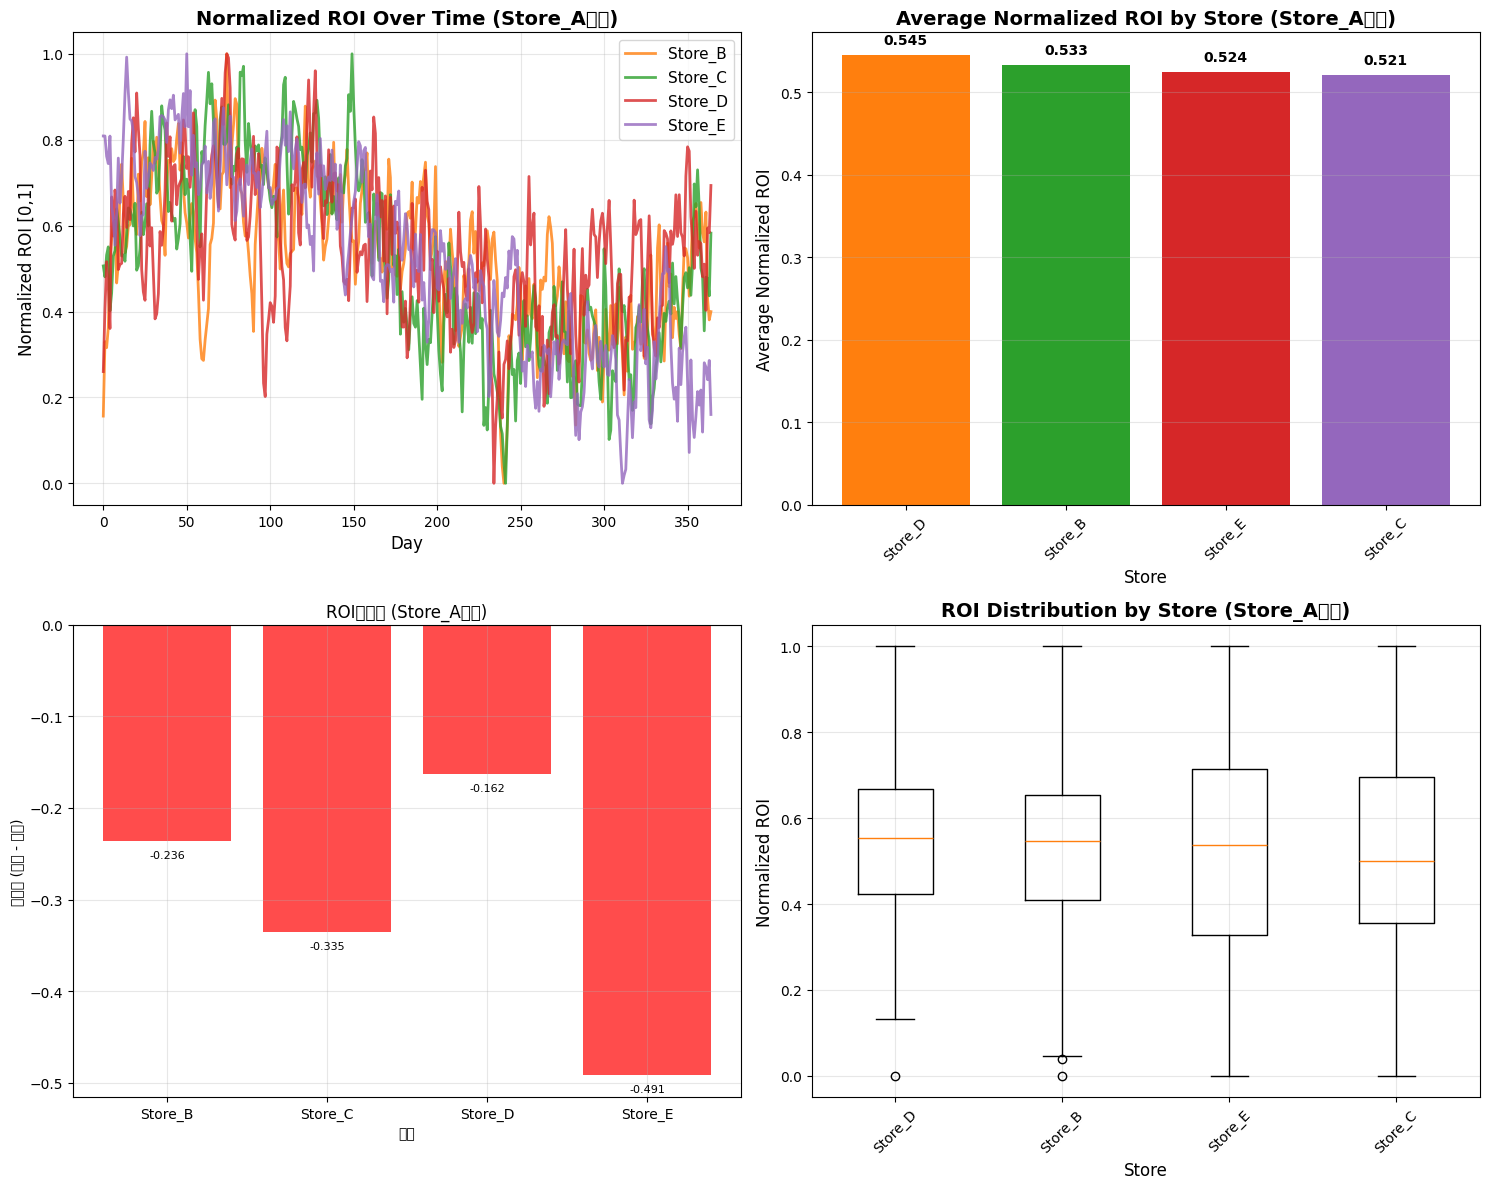

In [7]:
# Store_Aを取り除いた分析
print("=== Store_Aを除いた分析 ===")
print()

# Store_Aを除いたデータ
data_without_a = final_data[final_data['store'] != 'Store_A'].copy()

print(f"元のデータ数: {len(final_data)}")
print(f"Store_Aを除いたデータ数: {len(data_without_a)}")
print(f"除外されたデータ数: {len(final_data) - len(data_without_a)}")
print()

# Store_Aを除いた各店舗の平均
print("=== Store_Aを除いた各店舗の平均ROI ===")
store_averages_no_a = data_without_a.groupby('store')['roi_normalized'].mean().sort_values(ascending=False)

for store, avg_roi in store_averages_no_a.items():
    print(f"{store}: {avg_roi:.4f}")

print()
print("=== 平均値のランキング (Store_A除く) ===")
for i, (store, avg_roi) in enumerate(store_averages_no_a.items(), 1):
    print(f"{i}. {store}: {avg_roi:.4f}")

print()
print("=== 統計サマリー (Store_A除く) ===")
print(f"全体平均: {data_without_a['roi_normalized'].mean():.4f}")
print(f"最高平均: {store_averages_no_a.max():.4f} ({store_averages_no_a.idxmax()})")
print(f"最低平均: {store_averages_no_a.min():.4f} ({store_averages_no_a.idxmin()})")
print(f"標準偏差: {store_averages_no_a.std():.4f}")

# Store_Aを除いた最初の100日と最後の100日の比較
print("\n=== Store_Aを除いた最初の100日 vs 最後の100日の比較 ===")
comparison_results_no_a = []

for store in data_without_a['store'].unique():
    store_data = data_without_a[data_without_a['store'] == store].sort_values('day')
    
    # 最初の100日
    first_100 = store_data.head(100)['roi_normalized'].mean()
    
    # 最後の100日
    last_100 = store_data.tail(100)['roi_normalized'].mean()
    
    # 変化量
    change = last_100 - first_100
    change_pct = (change / first_100) * 100 if first_100 != 0 else 0
    
    comparison_results_no_a.append({
        'store': store,
        'first_100_avg': first_100,
        'last_100_avg': last_100,
        'change': change,
        'change_pct': change_pct
    })
    
    print(f"{store}:")
    print(f"  最初の100日平均: {first_100:.4f}")
    print(f"  最後の100日平均: {last_100:.4f}")
    print(f"  変化量: {change:+.4f} ({change_pct:+.2f}%)")
    print()

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Store_Aを除いた時系列グラフ
ax1 = axes[0, 0]
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
store_names_no_a = data_without_a['store'].unique()

for i, store in enumerate(store_names_no_a):
    store_data = data_without_a[data_without_a['store'] == store]
    ax1.plot(store_data['day'], store_data['roi_normalized'], 
             label=store, color=colors[i], linewidth=2, alpha=0.8)

ax1.set_title('Normalized ROI Over Time (Store_A除外)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Normalized ROI [0,1]', fontsize=12)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. Store_Aを除いた平均値のバープロット
ax2 = axes[0, 1]
bars = ax2.bar(range(len(store_averages_no_a)), store_averages_no_a.values, 
               color=colors[:len(store_averages_no_a)])
ax2.set_title('Average Normalized ROI by Store (Store_A除外)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Store', fontsize=12)
ax2.set_ylabel('Average Normalized ROI', fontsize=12)
ax2.set_xticks(range(len(store_averages_no_a)))
ax2.set_xticklabels(store_averages_no_a.index, rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, store_averages_no_a.values)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Store_Aを除いた変化量のバープロット
comparison_df_no_a = pd.DataFrame(comparison_results_no_a)
ax3 = axes[1, 0]
colors_change = ['green' if x > 0 else 'red' for x in comparison_df_no_a['change']]
bars = ax3.bar(comparison_df_no_a['store'], comparison_df_no_a['change'], 
               color=colors_change, alpha=0.7)
ax3.set_xlabel('店舗')
ax3.set_ylabel('変化量 (最後 - 最初)')
ax3.set_title('ROI変化量 (Store_A除外)')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, comparison_df_no_a['change'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if value > 0 else -0.01), 
             f'{value:+.3f}', ha='center', va='bottom' if value > 0 else 'top', fontsize=8)

# 4. Store_Aを除いた箱ひげ図
ax4 = axes[1, 1]
store_data_list_no_a = [data_without_a[data_without_a['store'] == store]['roi_normalized'].values 
                        for store in store_averages_no_a.index]
ax4.boxplot(store_data_list_no_a, labels=store_averages_no_a.index)
ax4.set_title('ROI Distribution by Store (Store_A除外)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Store', fontsize=12)
ax4.set_ylabel('Normalized ROI', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/harashimakoshi/CS332/332Project2/figures/analysis_without_store_a.png', 
            dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Store_Aを除いたデータを保存
output_path_no_a = '/Users/harashimakoshi/CS332/332Project2/data/espace_4stores_normalized.csv'
data_without_a.to_csv(output_path_no_a, index=False)

# 比較用に元のデータ（Store_A含む）も保存
original_output_path = '/Users/harashimakoshi/CS332/332Project2/data/espace_5stores_normalized.csv'
final_data.to_csv(original_output_path, index=False)


=== Store_Aを除いたデータの保存 ===

=== データ保存完了 ===
元のデータ（5店舗）: /Users/harashimakoshi/CS332/332Project2/data/espace_5stores_normalized.csv
Store_A除くデータ（4店舗）: /Users/harashimakoshi/CS332/332Project2/data/espace_4stores_normalized.csv


=== Store_Aを除いた分析の個別グラフ保存 ===


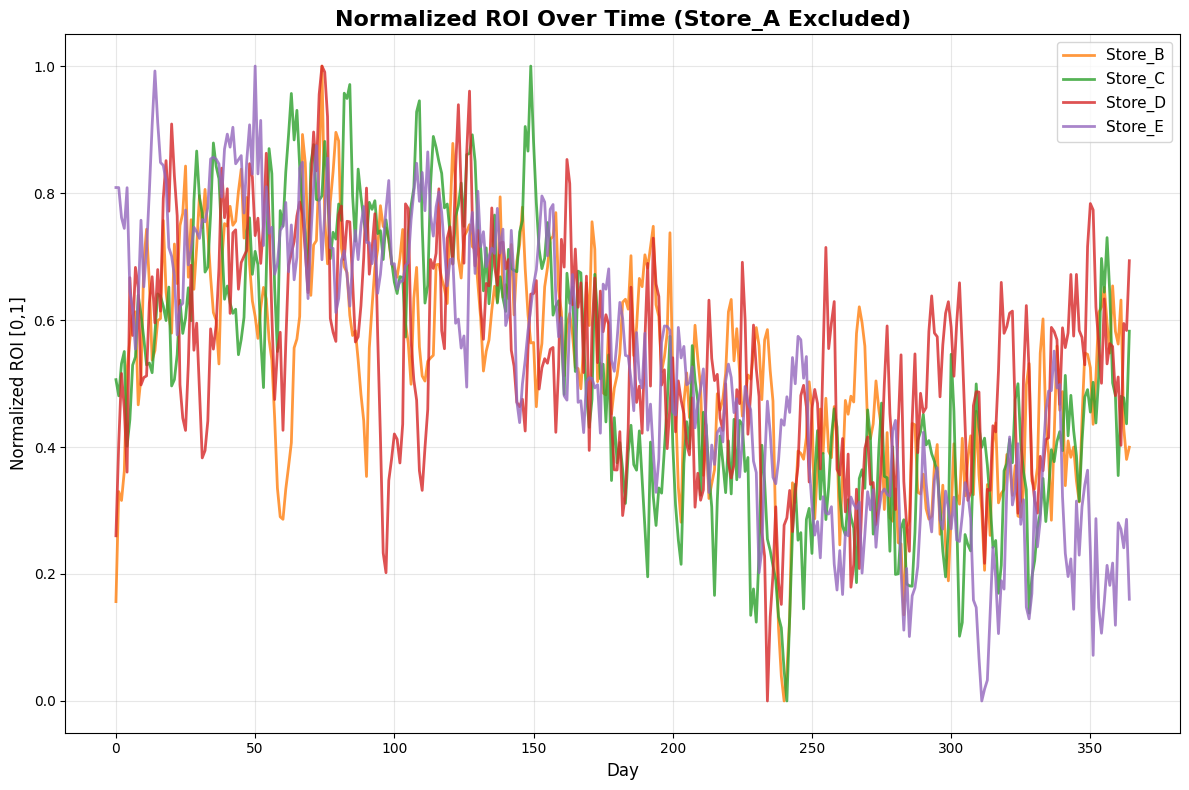

時系列グラフを保存: /Users/harashimakoshi/CS332/332Project2/figures/PP_data_timeseries_store_A_excluded.png


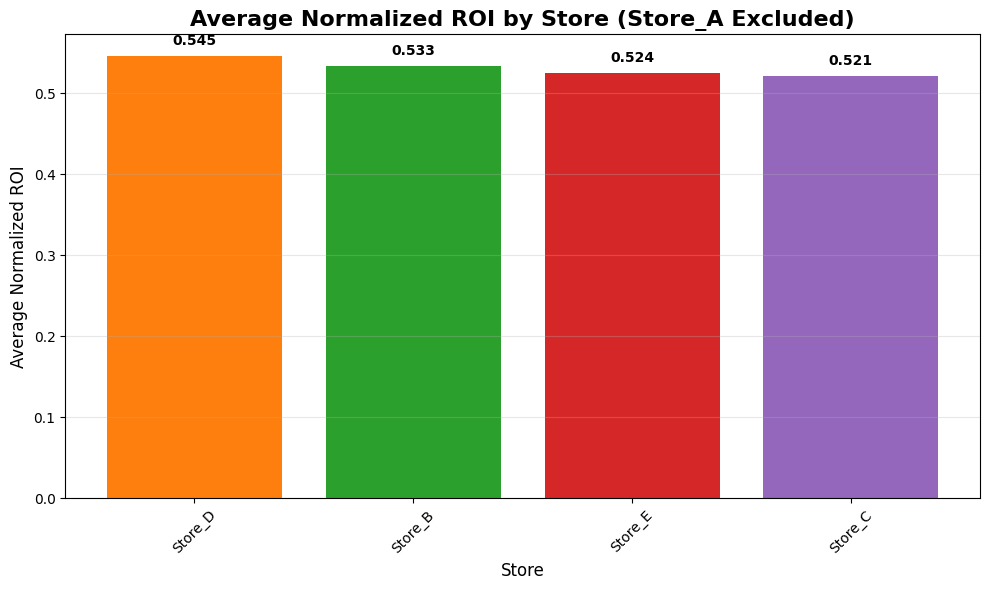

平均値バープロットを保存: /Users/harashimakoshi/CS332/332Project2/figures/PP_data_average_roi_by_store.png


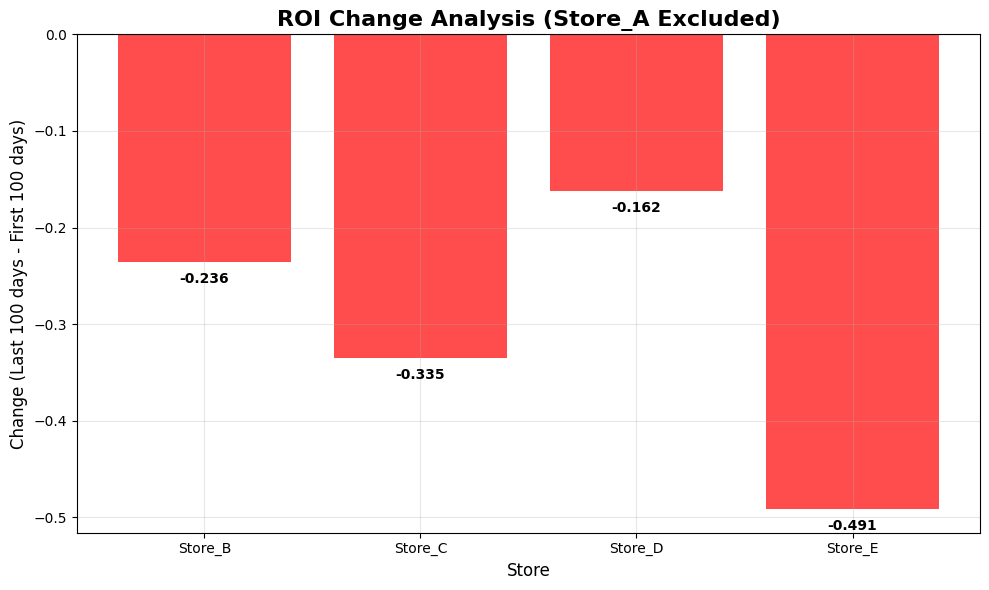

変化量バープロットを保存: /Users/harashimakoshi/CS332/332Project2/figures/PP_data_roi_change_analysis.png


/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_3248/2590787169.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(store_data_list_no_a, labels=store_averages_no_a.index)


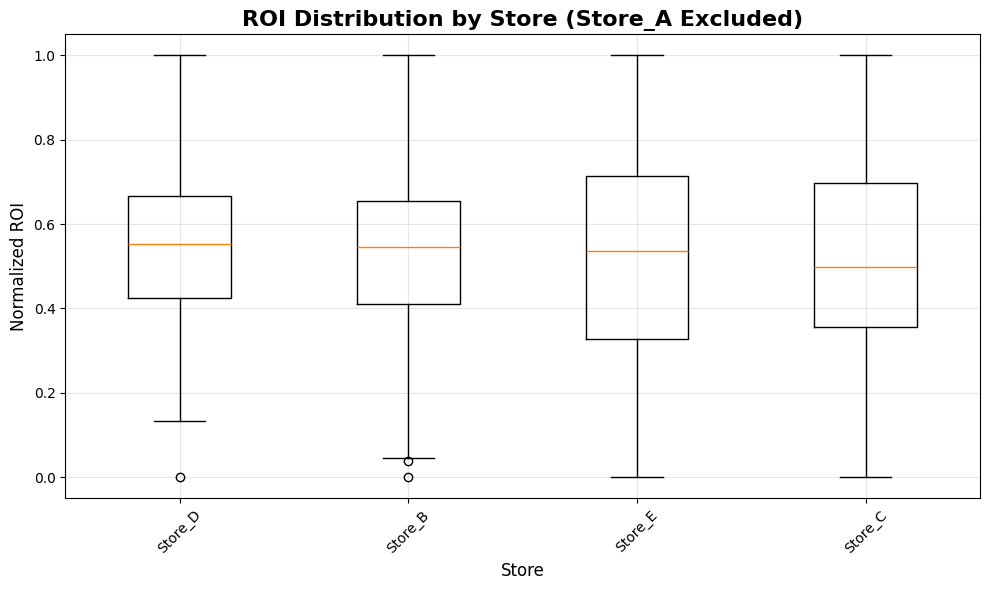

箱ひげ図を保存: /Users/harashimakoshi/CS332/332Project2/figures/PP_data_roi_distribution_by_store.png

=== 個別グラフ保存完了 ===
保存された画像:
1. 時系列グラフ: /Users/harashimakoshi/CS332/332Project2/figures/PP_data_timeseries_store_A_excluded.png
2. 平均値バープロット: /Users/harashimakoshi/CS332/332Project2/figures/PP_data_average_roi_by_store.png
3. 変化量バープロット: /Users/harashimakoshi/CS332/332Project2/figures/PP_data_roi_change_analysis.png
4. 箱ひげ図: /Users/harashimakoshi/CS332/332Project2/figures/PP_data_roi_distribution_by_store.png
すべて高解像度（300 DPI）で保存されました。


In [ ]:

# 1. 時系列グラフの個別保存
plt.figure(figsize=(12, 8))
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
store_names_no_a = data_without_a['store'].unique()

for i, store in enumerate(store_names_no_a):
    store_data = data_without_a[data_without_a['store'] == store]
    plt.plot(store_data['day'], store_data['roi_normalized'], 
             label=store, color=colors[i], linewidth=2, alpha=0.8)

plt.title('Normalized ROI Over Time (Store_A Excluded)', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Normalized ROI [0,1]', fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 時系列グラフを保存
timeseries_fig_path = '/Users/harashimakoshi/CS332/332Project2/figures/PP_data_timeseries_store_A_excluded.png'
plt.savefig(timeseries_fig_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"時系列グラフを保存: {timeseries_fig_path}")

# 2. 平均値バープロットの個別保存
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(store_averages_no_a)), store_averages_no_a.values, 
               color=colors[:len(store_averages_no_a)])
plt.title('Average Normalized ROI by Store (Store_A Excluded)', fontsize=16, fontweight='bold')
plt.xlabel('Store', fontsize=12)
plt.ylabel('Average Normalized ROI', fontsize=12)
plt.xticks(range(len(store_averages_no_a)), store_averages_no_a.index, rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, store_averages_no_a.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

# 平均値バープロットを保存
avg_bar_fig_path = '/Users/harashimakoshi/CS332/332Project2/figures/PP_data_average_roi_by_store.png'
plt.savefig(avg_bar_fig_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"平均値バープロットを保存: {avg_bar_fig_path}")

# 3. 変化量バープロットの個別保存
plt.figure(figsize=(10, 6))
comparison_df_no_a = pd.DataFrame(comparison_results_no_a)
colors_change = ['green' if x > 0 else 'red' for x in comparison_df_no_a['change']]
bars = plt.bar(comparison_df_no_a['store'], comparison_df_no_a['change'], 
               color=colors_change, alpha=0.7)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Change (Last 100 days - First 100 days)', fontsize=12)
plt.title('ROI Change Analysis (Store_A Excluded)', fontsize=16, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, comparison_df_no_a['change'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if value > 0 else -0.01), 
             f'{value:+.3f}', ha='center', va='bottom' if value > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()

# 変化量バープロットを保存
change_bar_fig_path = '/Users/harashimakoshi/CS332/332Project2/figures/PP_data_roi_change_analysis.png'
plt.savefig(change_bar_fig_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"変化量バープロットを保存: {change_bar_fig_path}")

# 4. 箱ひげ図の個別保存
plt.figure(figsize=(10, 6))
store_data_list_no_a = [data_without_a[data_without_a['store'] == store]['roi_normalized'].values 
                        for store in store_averages_no_a.index]
plt.boxplot(store_data_list_no_a, labels=store_averages_no_a.index)
plt.title('ROI Distribution by Store (Store_A Excluded)', fontsize=16, fontweight='bold')
plt.xlabel('Store', fontsize=12)
plt.ylabel('Normalized ROI', fontsize=12)
plt.tick_params(axis='x', rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()

# 箱ひげ図を保存
boxplot_fig_path = '/Users/harashimakoshi/CS332/332Project2/figures/PP_data_roi_distribution_by_store.png'
plt.savefig(boxplot_fig_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"箱ひげ図を保存: {boxplot_fig_path}")

print(f"\n=== 個別グラフ保存完了 ===")
print(f"保存された画像:")
print(f"1. 時系列グラフ: {timeseries_fig_path}")
print(f"2. 平均値バープロット: {avg_bar_fig_path}")
print(f"3. 変化量バープロット: {change_bar_fig_path}")
print(f"4. 箱ひげ図: {boxplot_fig_path}")
print(f"すべて高解像度（300 DPI）で保存されました。")
